provided a DATASET of ~1.7M records of posts collected from Reddit using Google big query.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import accuracy_score

In [4]:
data=pd.read_csv("MBTI 500.csv")

In [5]:
data

,posts,type
0,know intj tool use interaction people excuse a...,INTJ
1,rap music ehh opp yeah know valid well know fa...,INTJ
2,preferably p hd low except wew lad video p min...,INTJ
3,drink like wish could drink red wine give head...,INTJ
4,space program ah bad deal meing freelance max ...,INTJ
...,...,...
106062,stay frustrate world life want take long nap w...,INFP
106063,fizzle around time mention sure mistake thing ...,INFP
106064,schedule modify hey w intp strong wing underst...,INFP
106065,enfj since january busy schedule able spend li...,INFP


<AxesSubplot:>

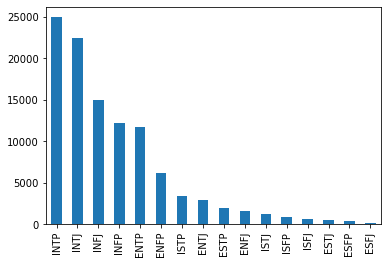

In [6]:
data['type'].value_counts().plot(kind='bar')

In [7]:
data['type'].value_counts() # INTP 24961, ESFJ 181 

INTP    24961
INTJ    22427
INFJ    14963
INFP    12134
ENTP    11725
ENFP     6167
ISTP     3424
ENTJ     2955
ESTP     1986
ENFJ     1534
ISTJ     1243
ISFP      875
ISFJ      650
ESTJ      482
ESFP      360
ESFJ      181
Name: type, dtype: int64

In [8]:
data['energy']=data['type'].apply(lambda x:x[0])
data['recognize']=data['type'].apply(lambda x:x[1])
data['judgment']=data['type'].apply(lambda x:x[2])
data['plan']=data['type'].apply(lambda x:x[3])

In [9]:
data

,posts,type,energy,recognize,judgment,plan
0,know intj tool use interaction people excuse a...,INTJ,I,N,T,J
1,rap music ehh opp yeah know valid well know fa...,INTJ,I,N,T,J
2,preferably p hd low except wew lad video p min...,INTJ,I,N,T,J
3,drink like wish could drink red wine give head...,INTJ,I,N,T,J
4,space program ah bad deal meing freelance max ...,INTJ,I,N,T,J
...,...,...,...,...,...,...
106062,stay frustrate world life want take long nap w...,INFP,I,N,F,P
106063,fizzle around time mention sure mistake thing ...,INFP,I,N,F,P
106064,schedule modify hey w intp strong wing underst...,INFP,I,N,F,P
106065,enfj since january busy schedule able spend li...,INFP,I,N,F,P


In [10]:
data['energy'].value_counts() # I : 80677, E : 25390
data['recognize'].value_counts() # N : 96866, S : 9201
data['judgment'].value_counts() # T : 69203, F : 36864
data['plan'].value_counts() # P : 61632, J : 44435

# N or S 의 데이터가 10 대1로 비대칭임
# 그다음순으로 I or E가 3대1로 비대칭

P    61632
J    44435
Name: plan, dtype: int64

In [11]:
data['voca count']=data['posts'].apply(lambda x:x.split()).apply(lambda x:len(x))

<AxesSubplot:xlabel='voca count', ylabel='Count'>

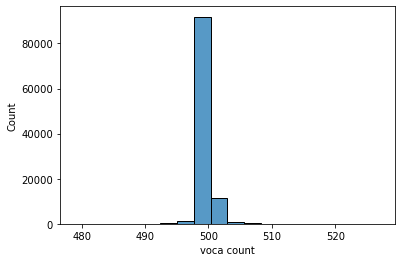

In [12]:
sns.histplot(data['voca count'])

In [13]:
data['voca count'].describe()

count    106067.000000
mean        500.019818
std           1.209997
min         479.000000
25%         500.000000
50%         500.000000
75%         500.000000
max         527.000000
Name: voca count, dtype: float64

In [14]:
# 단어들 토큰화
# 불용어 제거

In [15]:
import nltk
from nltk.corpus import stopwords # 불용어 제거
from nltk.tokenize import word_tokenize # 단어들 토큰화

In [16]:
import re

In [17]:
# 길이가 1~2인 단어들을 정규 표현식을 이용하여 삭제
shortword = re.compile(r'\W*\b\w{1,2}\b')
def delete_shortword(words):
    return shortword.sub('', words)

In [18]:
data['posts']=data['posts'].apply(lambda x : delete_shortword(x))

In [19]:
data['tokenization']=data['posts'].apply(lambda x:word_tokenize(x))

In [20]:
# 불용어 추가

In [21]:
stop = stopwords.words('english') # 불용어
# stop.extend(['intj','entj','istj','estj','infj','enfj','isfj','esfj','intp','entp','istp','estp','infp','enfp','isfp','esfp'])
stop.extend(['smv','iii','ouiiiiiiiiiiiiiiiiiiiiiiiiii','liiiiiike','boiiii'])

In [22]:
data['tokenization'] = data['tokenization'].apply(lambda x: [item for item in x if item not in stop])

In [23]:
def list2str(words):
    return ' '.join(words)

In [24]:
data['clean posts'] = data['tokenization'].apply(list2str)

In [25]:
data

,posts,type,energy,recognize,judgment,plan,voca count,tokenization,clean posts
0,know intj tool use interaction people excuse a...,INTJ,I,N,T,J,501,"[know, intj, tool, use, interaction, people, e...",know intj tool use interaction people excuse a...
1,rap music ehh opp yeah know valid well know fa...,INTJ,I,N,T,J,501,"[rap, music, ehh, opp, yeah, know, valid, well...",rap music ehh opp yeah know valid well know fa...
2,preferably low except wew lad video mind good ...,INTJ,I,N,T,J,501,"[preferably, low, except, wew, lad, video, min...",preferably low except wew lad video mind good ...
3,drink like wish could drink red wine give head...,INTJ,I,N,T,J,501,"[drink, like, wish, could, drink, red, wine, g...",drink like wish could drink red wine give head...
4,space program bad deal meing freelance max see...,INTJ,I,N,T,J,501,"[space, program, bad, deal, meing, freelance, ...",space program bad deal meing freelance max see...
...,...,...,...,...,...,...,...,...,...
106062,stay frustrate world life want take long nap w...,INFP,I,N,F,P,499,"[stay, frustrate, world, life, want, take, lon...",stay frustrate world life want take long nap w...
106063,fizzle around time mention sure mistake thing ...,INFP,I,N,F,P,499,"[fizzle, around, time, mention, sure, mistake,...",fizzle around time mention sure mistake thing ...
106064,schedule modify hey intp strong wing understan...,INFP,I,N,F,P,499,"[schedule, modify, hey, intp, strong, wing, un...",schedule modify hey intp strong wing understan...
106065,enfj since january busy schedule able spend li...,INFP,I,N,F,P,499,"[enfj, since, january, busy, schedule, able, s...",enfj since january busy schedule able spend li...


In [26]:
data.drop(['posts', 'voca count','tokenization'], axis=1, inplace=True)
# 열 정리

# Model (데이터셋 분류 체크)
#### TFIDF, SVC 활용

In [27]:
X = data['clean posts'] # features
y = data['type']  # labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [28]:
X

0         know intj tool use interaction people excuse a...
1         rap music ehh opp yeah know valid well know fa...
2         preferably low except wew lad video mind good ...
3         drink like wish could drink red wine give head...
4         space program bad deal meing freelance max see...
                                ...                        
106062    stay frustrate world life want take long nap w...
106063    fizzle around time mention sure mistake thing ...
106064    schedule modify hey intp strong wing understan...
106065    enfj since january busy schedule able spend li...
106066    feel like men good problem tell parent want te...
Name: clean posts, Length: 106067, dtype: object

In [29]:
# 구현 방법1

In [30]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [31]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [32]:
# tfidf_vectorizer.vocabulary_ # TF-IDF에 사용된 단어사전 체크

In [33]:
clf = LinearSVC()
clf.fit(X_train_tfidf, y_train)

LinearSVC()

In [34]:
y_pred=clf.predict(X_test_tfidf)

In [35]:
acc=accuracy_score(y_test, y_pred)*100
print("분류 정확도 : {:.2f} %".format(acc))

분류 정확도 : 83.14 %


In [36]:
# 구현 방법2 (Pipeline 함수 이용)

In [37]:
text_clf = Pipeline([('tfidf',TfidfVectorizer()),('clf',LinearSVC())])
text_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [38]:
y_pred2 = text_clf.predict(X_test)

In [39]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

        ENFJ       0.87      0.68      0.76       311
        ENFP       0.82      0.75      0.79      1224
        ENTJ       0.90      0.80      0.85       592
        ENTP       0.83      0.81      0.82      2304
        ESFJ       0.75      0.38      0.50        32
        ESFP       0.82      0.43      0.57        74
        ESTJ       0.91      0.80      0.85        96
        ESTP       0.95      0.90      0.92       407
        INFJ       0.82      0.85      0.83      2976
        INFP       0.79      0.83      0.81      2373
        INTJ       0.83      0.86      0.85      4445
        INTP       0.84      0.87      0.85      5093
        ISFJ       0.76      0.56      0.64       122
        ISFP       0.74      0.55      0.63       183
        ISTJ       0.86      0.65      0.74       242
        ISTP       0.90      0.80      0.84       740

    accuracy                           0.83     21214
   macro avg       0.84   

In [40]:
acc2=accuracy_score(y_test, y_pred2)*100
print("분류 정확도 : {:.2f} %".format(acc2))

분류 정확도 : 83.14 %


In [41]:
# 참고 : 언급된 단어 중 MBTI를 지칭하는('intj','entj','istj','estj'...) 를 삭제해서 분류하면
# 분류 정확도가 73%로 떨어짐